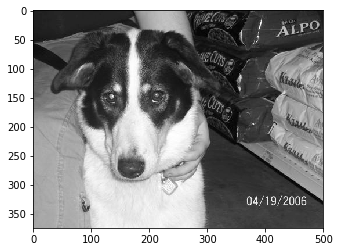

In [1]:
#IMPORT DES DEPENDANCES

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "/code/2.Images/Animaux"

CATEGORIES = ["Dog", "Cat"] # créer 2 catégories

for category in CATEGORIES: 
    path = os.path.join(DATADIR,category)  # créer un chemin vers les chiens et les chats 
    for img in os.listdir(path):  # itérer sur chaque image par chiens et chats (envion 25 000) 
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convertir en tableau 
        plt.imshow(img_array, cmap='gray')  # passage en noir et blanc
        plt.show()  # affichage!

        break  # nous en voulons juste une imgae pour le moment, alors pause 
    break 


In [2]:
print(img_array)

[[ 31  31  31 ...  31  31  31]
 [ 31  31  31 ...  29  29  29]
 [ 31  31  31 ...  26  26  26]
 ...
 [167 167 167 ...  71  71  71]
 [165 166 166 ...  73  73  73]
 [163 164 165 ...  73  73  74]]


In [3]:
print(img_array.shape) # c est une image de 500 de hauteur et 470 de large 
# il y a 3 canaux a cause de la couleur (RGV) 


(375, 500)


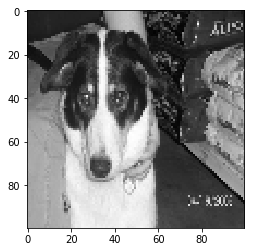

In [4]:
IMG_SIZE = 100 # nous mettons toutes des images à la meme taille 100)

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()


In [5]:
# CREATION DES DONNEES D ENTRAINEMENT 

 
training_data = []

def create_training_data():
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category)  # créer un chemin vers les chiens et les chats 
        class_num = CATEGORIES.index(category)  # obtenir la classification (0 ou 1). 0 = chien 1 = chat

        for img in tqdm(os.listdir(path)):  # itérer sur chaque image par chiens et chats 
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convertir en tableau 
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # redimentionner pour normaliser la taille des données
                training_data.append([new_array, class_num])  # ajoutez ceci à notre formation_data 
            except Exception as e:  # idans l'intérêt de garder la sortie propre ... 
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 12485/12485 [00:10<00:00, 1217.89it/s]

24915


In [6]:
import random

random.shuffle(training_data) # melange des donnees 

In [7]:
for sample in training_data[:10]:
    print(sample[1]) # test pour voir si les images ont bien été melangees

1
1
1
0
0
1
0
1
1
1


In [8]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

print(X[0].reshape(-1, IMG_SIZE, IMG_SIZE, 1))

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

[[[[ 87]
   [ 87]
   [ 86]
   ...
   [ 65]
   [ 29]
   [ 64]]

  [[ 87]
   [ 86]
   [ 85]
   ...
   [ 77]
   [ 92]
   [ 92]]

  [[ 87]
   [ 86]
   [ 86]
   ...
   [ 62]
   [ 76]
   [ 42]]

  ...

  [[217]
   [214]
   [211]
   ...
   [223]
   [221]
   [218]]

  [[218]
   [217]
   [215]
   ...
   [221]
   [221]
   [222]]

  [[216]
   [220]
   [213]
   ...
   [222]
   [222]
   [221]]]]


In [9]:
# SAUVEGARDE DES DONNEES 

# on les sauvegarde pour ne pas avoir à les calculer à chaque tour du modèle 

import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()



In [10]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
#from tensorflow.keras.callbacks import TensorBoard
import time

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

X = X/255.0

dense_layers = [0]
layer_sizes = [64]
conv_layers = [3]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = "{}-conv-{}-nodes-{}-dense-{}".format(conv_layer, layer_size, dense_layer, int(time.time()))
            print(NAME)

            model = Sequential()

            model.add(Conv2D(layer_size, (3, 3), input_shape=X.shape[1:]))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))

            for l in range(conv_layer-1):
                model.add(Conv2D(layer_size, (3, 3)))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))

            model.add(Flatten())

            for _ in range(dense_layer):
                model.add(Dense(layer_size))
                model.add(Activation('relu'))

            model.add(Dense(1))
            model.add(Activation('sigmoid'))

            
            model.compile(loss='binary_crossentropy',
                          optimizer='adam',
                          metrics=['accuracy'],
                          )

            model.fit(X, y,
                      batch_size=32,
                      epochs=10,
                      validation_split=0.3,
                      )

model.save('/code/3.Modeles/modelchiensetchats.model')

3-conv-64-nodes-0-dense-1599827505
Train on 17440 samples, validate on 7475 samples
Epoch 1/10
17440/17440 [==============================] - 185s 11ms/sample - loss: 0.6544 - accuracy: 0.6065 - val_loss: 0.5964 - val_accuracy: 0.6797
Epoch 2/10
17440/17440 [==============================] - 192s 11ms/sample - loss: 0.5446 - accuracy: 0.7288 - val_loss: 0.5030 - val_accuracy: 0.7559
Epoch 3/10
17440/17440 [==============================] - 181s 10ms/sample - loss: 0.4661 - accuracy: 0.7810 - val_loss: 0.4679 - val_accuracy: 0.7846
Epoch 4/10
17440/17440 [==============================] - 181s 10ms/sample - loss: 0.4189 - accuracy: 0.8075 - val_loss: 0.4326 - val_accuracy: 0.7979
Epoch 5/10
17440/17440 [==============================] - 189s 11ms/sample - loss: 0.3789 - accuracy: 0.8327 - val_loss: 0.3984 - val_accuracy: 0.8162
Epoch 6/10
17440/17440 [==============================] - 187s 11ms/sample - loss: 0.3495 - accuracy: 0.8471 - val_loss: 0.3794 - val_accuracy: 0.8264
Epoch 7/10